# Penalty Restriction(TensorFlow版本)
透過L1 & L2 Regularization來防止類神經網路overfitting

In [ ]:
import numpy as np
import tensorflow as tf
class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()

        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)      # [60000, 28, 28, 1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)        # [10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)    # [60000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):

        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]
    
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()    
        self.dense1 = tf.keras.layers.Dense(units=100, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L1L2(0.01,0.05))
#         self.dense1 = tf.keras.layers.Dense(units=100, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L1(0.01))
#        self.dense1 = tf.keras.layers.Dense(units=100, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01))

        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs):         # [batch_size, 28, 28, 1]
        x = self.flatten(inputs)    # [batch_size, 784]
        x = self.dense1(x)          # [batch_size, 100]
        x = self.dense2(x)          # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output

num_epochs = 5
batch_size = 50
learning_rate = 0.001

model = MLP()
data_loader = MNISTLoader()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_categorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], y_pred=y_pred)
print("test accuracy: %f" % sparse_categorical_accuracy.result())

batch 0: loss 2.435484
batch 1: loss 2.235003
batch 2: loss 2.219408
batch 3: loss 2.103619
batch 4: loss 2.093702
batch 5: loss 2.011176
batch 6: loss 1.976617
batch 7: loss 1.986470
batch 8: loss 1.821554
batch 9: loss 1.747742
batch 10: loss 1.700303
batch 11: loss 1.721067
batch 12: loss 1.631144
batch 13: loss 1.618835
batch 14: loss 1.594871
batch 15: loss 1.520527
batch 16: loss 1.482371
batch 17: loss 1.382504
batch 18: loss 1.166363
batch 19: loss 1.341701
batch 20: loss 1.364029
batch 21: loss 1.141860
batch 22: loss 1.105238
batch 23: loss 1.218396
batch 24: loss 1.143119
batch 25: loss 0.932499
batch 26: loss 1.122879
batch 27: loss 0.927348
batch 28: loss 0.918405
batch 29: loss 0.759680
batch 30: loss 0.909123
batch 31: loss 0.793296
batch 32: loss 0.776943
batch 33: loss 0.889736
batch 34: loss 0.835688
batch 35: loss 0.936955
batch 36: loss 0.720742
batch 37: loss 0.964241
batch 38: loss 0.769888
batch 39: loss 0.833201
batch 40: loss 0.672999
batch 41: loss 0.874691
ba

# Dropout(TensorFlow版本)
類似負重訓練的效果，在training時將部分neuron移除，test時再補回來!

In [1]:
import numpy as np
import tensorflow as tf
class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()

        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)      # [60000, 28, 28, 1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)        # [10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)    # [60000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):

        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]
    
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()    # Flatten层将除第一维（batch_size）以外的维度展平
        self.dense1 = tf.keras.layers.Dense(units=100, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L1(0.01))
        self.dense2 = tf.keras.layers.Dense(units=10)
        self.dropout_layer = tf.keras.layers.Dropout(rate=0.2)

    def call(self, inputs, training=None):         # [batch_size, 28, 28, 1]
        x = self.flatten(inputs)    # [batch_size, 784]
        x = self.dense1(x)          # [batch_size, 100]
        x = self.dropout_layer(x, training=training)
        x = self.dense2(x)          # [batch_size, 10]
        x = self.dropout_layer(x, training=training)
        output = tf.nn.softmax(x)
        return output

num_epochs = 5
batch_size = 128
learning_rate = 0.001

model = MLP()
# model.compile
data_loader = MNISTLoader()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

num_batches = int(data_loader.num_train_data // batch_size * num_epochs)

for batch_index in range(num_batches):
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X, training=True) # 這裡一定要加上 training = true代表訓練預測時使用負重訓練
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    
    

sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_categorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], y_pred=y_pred)
print("test accuracy: %f" % sparse_categorical_accuracy.result())

batch 0: loss 2.456346
batch 1: loss 2.320688
batch 2: loss 2.200954
batch 3: loss 2.174162
batch 4: loss 2.087512
batch 5: loss 2.018888
batch 6: loss 1.932891
batch 7: loss 1.857764
batch 8: loss 1.706555
batch 9: loss 1.727158
batch 10: loss 1.660357
batch 11: loss 1.626040
batch 12: loss 1.563582
batch 13: loss 1.467975
batch 14: loss 1.393619
batch 15: loss 1.441103
batch 16: loss 1.382273
batch 17: loss 1.405621
batch 18: loss 1.331125
batch 19: loss 1.237661
batch 20: loss 1.198734
batch 21: loss 1.167284
batch 22: loss 1.263037
batch 23: loss 1.148620
batch 24: loss 1.137599
batch 25: loss 1.130811
batch 26: loss 1.054866
batch 27: loss 1.044715
batch 28: loss 1.105528
batch 29: loss 1.040915
batch 30: loss 1.029762
batch 31: loss 1.098210
batch 32: loss 0.927978
batch 33: loss 1.096447
batch 34: loss 0.885126
batch 35: loss 1.023054
batch 36: loss 0.890171
batch 37: loss 1.030002
batch 38: loss 0.970649
batch 39: loss 0.881382
batch 40: loss 0.911616
batch 41: loss 0.937124
ba

# Dropout(Keras)

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.compat.v1.reset_default_graph()

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape([x_train.shape[0], -1])
x_test = x_test.reshape([x_test.shape[0], -1])
print(x_train.shape, ' ', y_train.shape)
print(x_test.shape, ' ', y_test.shape)

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(784,)),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.L1(0.01))
])


#keras.optimizers.Adagrad(learning_rate=0.01)
#keras.optimizers.Adam(learning_rate=0.01)
#keras.optimizers.RMSprop(learning_rate=0.01)

# provide labels as one_hot representation => tf.keras.losses.CategoricalCrossentropy
# provide labels as integers => tf.keras.losses.SparseCategoricalCrossentropy 
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_split=0.3, verbose=2)

(60000, 784)   (60000,)
(10000, 784)   (10000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
____

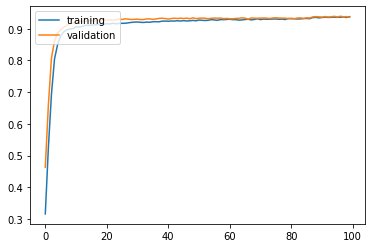

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [10]:
result = model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 0s 601us/step - loss: 0.4262 - accuracy: 0.9404
[0.42615756392478943, 0.9404000043869019]


# Batch Normalization(TensorFlow版本)
透過將每一個batch的資料正規化來縮短模型訓練時間

In [2]:
# 增加訓練速度 (丟進激活函數之前先做Batch Normalization，簡稱BN層)
import numpy as np
import tensorflow as tf
class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()

        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)      # [60000, 28, 28, 1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)        # [10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)    # [60000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):

        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]
    
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()
        
        self.dense1 = tf.keras.layers.Dense(units=100)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.ac1 = tf.keras.layers.LeakyReLU(alpha=0.2)
        
        self.dense2 = tf.keras.layers.Dense(units=10)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.ac2 = tf.keras.layers.LeakyReLU(alpha=0.2)

    def call(self, inputs):         # [batch_size, 28, 28, 1]
        x = self.flatten(inputs)    # [batch_size, 784]
        x = self.dense1(x)          # [batch_size, 100]
        x = self.bn1(x)
        x = self.ac1(x)
        
        x = self.dense2(x)          # [batch_size, 10]
        x = self.bn2(x)
        x = self.ac2(x)

        output = tf.nn.softmax(x)
        return output

num_epochs = 5
batch_size = 1000
learning_rate = 0.001

model = MLP()
data_loader = MNISTLoader()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_categorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], y_pred=y_pred)
print("test accuracy: %f" % sparse_categorical_accuracy.result())

batch 0: loss 2.395871
batch 1: loss 2.302521
batch 2: loss 2.223227
batch 3: loss 2.127664
batch 4: loss 2.082026
batch 5: loss 2.010781
batch 6: loss 1.953032
batch 7: loss 1.892682
batch 8: loss 1.830975
batch 9: loss 1.719758
batch 10: loss 1.677893
batch 11: loss 1.581999
batch 12: loss 1.517661
batch 13: loss 1.482351
batch 14: loss 1.403175
batch 15: loss 1.358136
batch 16: loss 1.222202
batch 17: loss 1.243408
batch 18: loss 1.194086
batch 19: loss 1.110593
batch 20: loss 1.021773
batch 21: loss 0.942443
batch 22: loss 0.911492
batch 23: loss 0.880218
batch 24: loss 0.804583
batch 25: loss 0.768039
batch 26: loss 0.785902
batch 27: loss 0.724358
batch 28: loss 0.699926
batch 29: loss 0.649268
batch 30: loss 0.610541
batch 31: loss 0.590848
batch 32: loss 0.602088
batch 33: loss 0.553420
batch 34: loss 0.570544
batch 35: loss 0.587716
batch 36: loss 0.547053
batch 37: loss 0.570801
batch 38: loss 0.541263
batch 39: loss 0.543303
batch 40: loss 0.511966
batch 41: loss 0.480443
ba

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.compat.v1.reset_default_graph()

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape([x_train.shape[0], -1])
x_test = x_test.reshape([x_test.shape[0], -1])
print(x_train.shape, ' ', y_train.shape)
print(x_test.shape, ' ', y_test.shape)

model = keras.Sequential([
    layers.Dense(100, input_shape=(784,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dense(10, activation='softmax')

])


#keras.optimizers.Adagrad(learning_rate=0.01)
#keras.optimizers.Adam(learning_rate=0.01)
#keras.optimizers.RMSprop(learning_rate=0.01)

# provide labels as one_hot representation => tf.keras.losses.CategoricalCrossentropy
# provide labels as integers => tf.keras.losses.SparseCategoricalCrossentropy 
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_split=0.3, verbose=2)

result = model.evaluate(x_test, y_test)
print(result)

(60000, 784)   (60000,)
(10000, 784)   (10000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,910
Trainable params: 79,710
Non-trainable params: 200
_________________________________________________________________
Epoch 1/100
165/165 - 0s - loss: 0.4803 - accuracy: 0.8596 - val_loss: 0.2738 - val_accuracy: 0.9233
Epoch 2/100
165/165 - 0s - loss: 0.2487 - accuracy: 0.9308 - val_loss: 0.2292 - val_accuracy: 0.936